#### クラス編成
- 課題整理(条件)
  - 全生徒を1つのクラスに割り当てる
  - クラス人数は39人以上40人以下
  - 男子生徒、女子生徒は20人以下
  - 学力試験のクラス平均点は学年平均の±10点
  - リーダ気質の生徒を2人以上
  - 特別支援生徒は1人以下
  - 特定ペアの生徒は別クラスとする

- List
  - $S$ : Students list
  - $C$ : Class list
  - $S_{male}$ : Men list
  - $S_{female}$ : Women list
  - $S_{leader}$ : leaders list
  - $S_{support}$ : supports list
  - $S_{specific}$ : Specific Pairs list
- Variable
  - $x_{s,c} \in \{0, 1\} (s\in S, c\in C)$
- Constant
  - $score_s$ : Score of students
  - $score_{mean}$ : Score of mean
- Constraints
  1. $\sum_{c\in C} x_{s,c} = 1 \quad (s \in S)$
  2. $\sum_{s\in S} x_{s,c} \ge 39 \quad (c \in C), \quad \sum_{s\in S} x_{s,c} \le 40 \quad (c \in C)$
  3. $\sum_{s\in S_{male}} x_{s,c} \le 20 \quad (c \in C), \quad \sum_{s\in S_{female}} x_{s,c} \le 20 \quad (c \in C)$
  4. $\sum_{S_{leader}}x_{s,c} \le 2$
  5. $\sum_{S_{support}}x_{s,c} \le 1$
  6. $(score_{mean}-10) \cdot \sum_{s\in S} x_{s,c} \ge \sum_{s\in S} score_s \cdot x_{s,c}, \quad \sum_{s\in S} score_s \cdot x_{s,c} \le (score_{mean}+10) \cdot \sum_{s\in S} x_{s,c}$
  7. $x_{s1,c} + x_{s2,c} \le 1$
- Objective
  - None(Maximize)

In [1]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math

In [2]:
glob('../*/*school/*.csv')

['..\\PyOptBook-main\\3.school\\students.csv',
 '..\\PyOptBook-main\\3.school\\student_pairs.csv']

In [3]:
students_df = pd.read_csv(glob('../*/*school/students.csv')[0])
student_pairs_df = pd.read_csv(glob('../*/*school/student_pairs.csv')[0])

In [4]:
students_df.head(3)

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350


In [5]:
students_df['student_id'].nunique()

318

In [6]:
students_df['gender'].value_counts()

gender
0    160
1    158
Name: count, dtype: int64

In [7]:
students_df['leader_flag'].value_counts()

leader_flag
0    301
1     17
Name: count, dtype: int64

In [8]:
students_df['support_flag'].value_counts()

support_flag
0    314
1      4
Name: count, dtype: int64

In [9]:
students_df['score'].describe()

count    318.000000
mean     303.644654
std       65.179995
min       88.000000
25%      261.000000
50%      310.000000
75%      350.000000
max      485.000000
Name: score, dtype: float64

<Axes: >

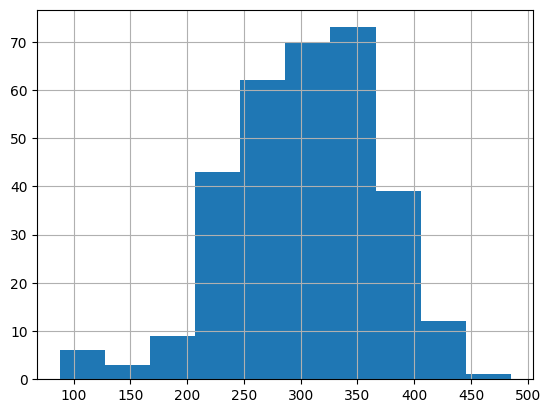

In [10]:
students_df['score'].hist()

In [11]:
student_pairs_df.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


数理モデル定義

In [12]:
prob = LpProblem('ClassAssignmentProblem', LpMaximize)

変数定義

In [13]:
S = students_df['student_id'].to_list()
class_num = math.ceil(students_df['student_id'].count()/40)
C = [chr(i+65) for i in range(class_num)]
SC = [(s, c) for s in S for c in C]

x = LpVariable.dicts('x', SC, cat='Binary')

条件定義

In [14]:
# 生徒の振り分け式 x1a + x1b + … + x1h == 1
for s in S:
    prob += lpSum([x[s, c] for c in C]) == 1

In [15]:
# クラス人数
for c in C:
    prob += lpSum([x[s, c] for s in S]) >= 39
    prob += lpSum([x[s, c] for s in S]) <= 40

In [16]:
# クラス男女人数
S_male = students_df['student_id'][students_df['gender'] == 1].to_list()
S_female = students_df['student_id'][students_df['gender'] == 0].to_list()
for c in C:
    prob += lpSum([x[s, c] for s in S_male]) <= 20
    prob += lpSum([x[s, c] for s in S_female]) <= 20

In [17]:
# 平均点差 ±10点
score_mean = students_df['score'].mean()
score = students_df.set_index('student_id').to_dict()['score']

for c in C:
    prob += (score_mean - 10) * lpSum([x[s, c] for s in S]) <= lpSum([x[s, c]*score[s] for s in S])
    prob += lpSum([x[s, c]*score[s] for s in S]) <= (score_mean + 10) * lpSum([x[s, c] for s in S]) 

In [18]:
# リーダー
S_leader = students_df['student_id'][students_df['leader_flag'] == 1].to_list()

for c in C:
    prob += lpSum([x[s, c] for s in S_leader]) >= 2

In [19]:
# サポート
S_support = students_df['student_id'][students_df['support_flag'] == 1].to_list()

for c in C:
    prob += lpSum([x[s, c] for s in S_support]) <= 1

In [20]:
# 特定ペアの排除
SS = [(row.student_id1, row.student_id2) for row in student_pairs_df.itertuples()]

for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

初期クラス編成を成績順で追加

In [21]:
students_df['score_rank'] = students_df['score'].rank(ascending=False, method='first')

class_dic = {i:chr(i+65) for i in range(8)}

students_df['init_assigned_class'] = students_df['score_rank'].map(lambda x:x % 8).map(class_dic)

init_flag = {(s, c): 0 for s in S for c in C}
init_flag
for row in students_df.itertuples():
    init_flag[row.student_id, row.init_assigned_class] == 1

# fig, axs = plt.subplots(2, 4, figsize=(14, 6))
# for i, c in enumerate(C):
#     cls_df = students_df[students_df['init_assigned_class']==c]
#     ax = fig.add_subplot(
#         2, 4, i+1,
#         xlabel = 'Score', ylabel = 'num',
#         xlim=(0, 500), ylim=(0, 20),
#         title=f'Class : {c}'
#         )
#     ax.hist(cls_df['score'], bins=range(0, 500, 40))
# plt.tight_layout()
# plt.show()

目的関数の追加

In [22]:
# 初期編成とできるだけ一致させる
prob += lpSum([x[s, c] * init_flag[s, c] for s, c in SC])

In [23]:
status = prob.solve()
print(status)
print('Status:', LpStatus[status])

1
Status: Optimal


In [24]:
# 結果表示
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s, c].value() == 1]

for c, Ss in C2Ss.items():
    print(f'Class: {c}')
    print(f'Num: {len(Ss)}')
    print(f'Students: {Ss}')
    print()

Class: A
Num: 40
Students: [2, 9, 19, 39, 42, 63, 65, 71, 79, 83, 85, 88, 99, 101, 109, 111, 123, 126, 136, 138, 145, 148, 165, 168, 173, 177, 179, 180, 193, 199, 206, 224, 233, 240, 246, 264, 267, 291, 292, 298]

Class: B
Num: 39
Students: [1, 11, 15, 43, 48, 50, 70, 82, 89, 91, 102, 104, 113, 114, 120, 121, 124, 127, 134, 149, 159, 167, 170, 176, 190, 203, 213, 220, 222, 231, 238, 245, 270, 275, 276, 283, 287, 290, 317]

Class: C
Num: 40
Students: [3, 14, 23, 25, 27, 31, 33, 41, 49, 53, 54, 58, 73, 93, 97, 98, 107, 122, 152, 156, 160, 171, 187, 210, 211, 217, 219, 227, 236, 242, 254, 258, 260, 268, 273, 274, 277, 278, 301, 318]

Class: D
Num: 40
Students: [10, 13, 16, 20, 36, 37, 51, 56, 59, 61, 67, 68, 75, 84, 92, 108, 128, 139, 140, 142, 146, 158, 161, 175, 183, 192, 198, 200, 221, 225, 235, 241, 252, 255, 256, 257, 266, 284, 293, 316]

Class: E
Num: 40
Students: [4, 5, 21, 22, 24, 38, 69, 72, 78, 87, 96, 105, 106, 115, 129, 132, 141, 143, 150, 154, 164, 166, 184, 189, 195, 196, 19

確認

In [25]:
# 全生徒が割り当てられている
for s in S:
    assigned_class = [c for c in C if x[s, c].value() == 1]
    if len(assigned_class) != 1:
        print('error:', s, assigned_class)

In [26]:
result_dt = students_df.copy()
# クラス割り当て追加
S2C = {s:c for s in S for c in C if x[s, c].value()==1}
result_dt['assigned_class'] = result_dt['student_id'].map(S2C)
result_dt.head()

,student_id,gender,leader_flag,support_flag,score,score_rank,init_assigned_class,assigned_class
0,1,0,0,0,335,109.0,F,B
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,C
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,E


In [27]:
# 各クラスの人数
result_dt.groupby('assigned_class')['student_id'].count()

assigned_class
A    40
B    39
C    40
D    40
E    40
F    40
G    40
H    39
Name: student_id, dtype: int64

In [28]:
# 男女の人数
result_dt.groupby(['assigned_class', 'gender'])['student_id'].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         19
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         20
G               0         20
                1         20
H               0         20
                1         19
Name: student_id, dtype: int64

In [29]:
# 平均点
result_dt.groupby(['assigned_class'])['score'].mean() - score_mean
score_mean - result_dt.groupby(['assigned_class'])['score'].mean()

assigned_class
A   -3.230346
B    9.926705
C   -8.480346
D   -6.205346
E    9.094654
F    4.119654
G   -9.555346
H    4.695936
Name: score, dtype: float64

In [30]:
# リーダー
result_dt.groupby(['assigned_class'])['leader_flag'].sum()

assigned_class
A    3
B    2
C    2
D    2
E    2
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [31]:
# サポート
result_dt.groupby(['assigned_class'])['support_flag'].sum()

assigned_class
A    0
B    0
C    1
D    0
E    1
F    0
G    1
H    1
Name: support_flag, dtype: int64

In [32]:
# 特定ペア
for i, (s1, s2) in enumerate(SS):
    print('case:', i+1, end=', ')
    c1 = S2C[s1]
    c2 = S2C[s2]
    print(f's1 :{s1}-{c1}', end=', ')
    print(f's2 :{s2}-{c2}', end=', ')
    print()

case: 1, s1 :118-G, s2 :189-E, 
case: 2, s1 :72-E, s2 :50-B, 
case: 3, s1 :314-H, s2 :233-A, 


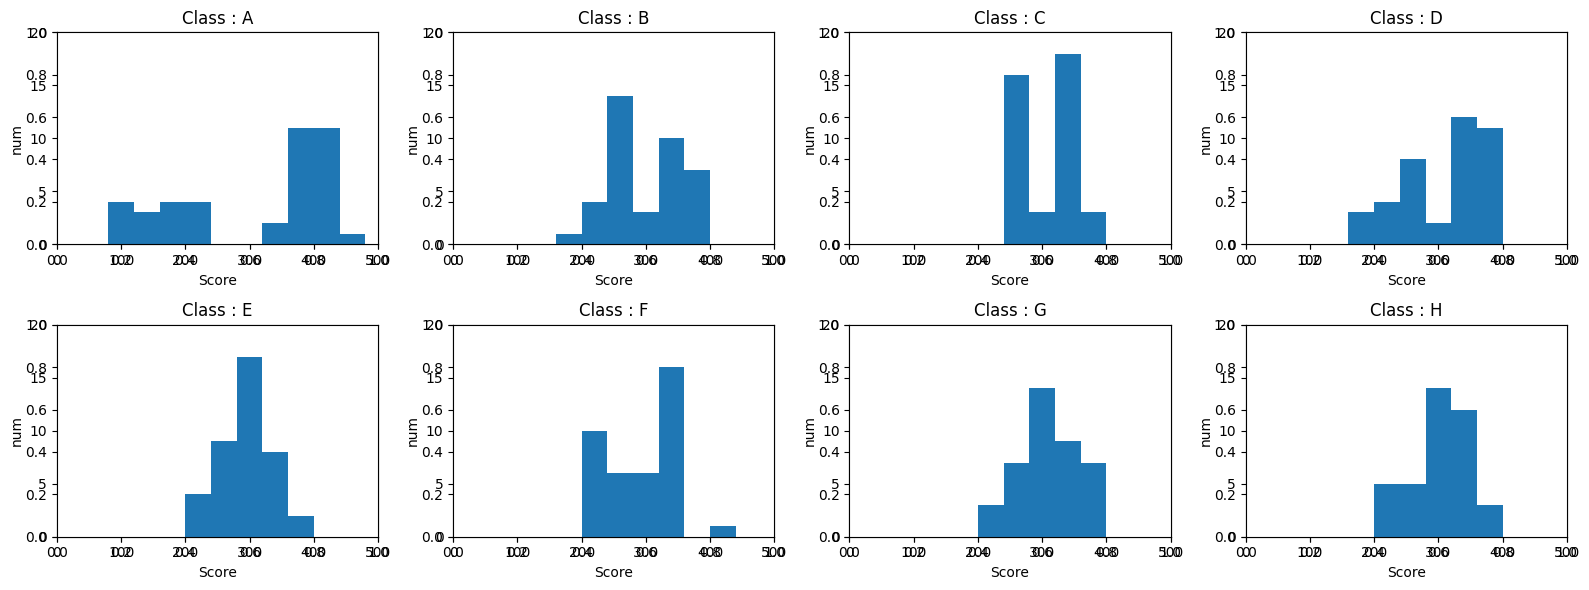

In [33]:
fig, axs = plt.subplots(2, 4, figsize=(16, 6))
for i, c in enumerate(C):
    cls_df = result_dt[result_dt['assigned_class']==c]
    ax = fig.add_subplot(
        2, 4, i+1,
        xlabel = 'Score', ylabel = 'num',
        xlim=(0, 500), ylim=(0, 20),
        title=f'Class : {c}'
        )
    ax.hist(cls_df['score'], bins=range(0, 500, 40))
plt.tight_layout()